<a href="https://colab.research.google.com/github/ziatdinovmax/Semi-Supervised-VAE-nanoparticles/blob/main/ssrVAE_paper_synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

May 23rd, 2021

- Semi-supervised VAE with rotational and translational invariances
- Based on [PyroVED library](https://github.com/ziatdinovmax/pyroVED) by Maxim Ziatdinov 
- Applied to synthetic dataset of card suites
- The proof-of-concept analysis by Maxim Ziatdinov
- Analysis of robustness with respect to noise and distrotions by Yongtao Liu
- Supported by the [CSSAS EFRC center](https://www.cssas-efrc.com/)

#### **Dependencies**

- pytorch==1.8.0
- pyroved==0.1.2


# Semi-supervised VAE for model data with orientational disorder


---

This notebook demonstrates how to use a variational autoencoder (VAE) to generalize from a small subset of labeled data with the weak orientational disorder to a large volume of unlabelled data with a much stronger orientational disorder.

---

In [ ]:
#@title Installations
!pip install --upgrade torch==1.8.0 torchvision==0.9.0
!pip install -q pyroved==0.1.2 kornia

In [3]:
#@title Imports
import pyroved as pv

import kornia as K
import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import torch.tensor as tt
import numpy as np
import matplotlib.pyplot as plt

assert torch.__version__ == "1.8.0"
assert pv.__version__ == "0.1.2"

In [4]:
#@title Helper function
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    !gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
    !unzip -o -qq cards.zip
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


def transform_images(*args, **kwargs):
    card1, card2, card3, card4 = args
    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = kwargs.get("shear")
    z = kwargs.get("scale")
    n_samples = kwargs.get("samples", 3000)
    torch.manual_seed(kwargs.get("seed", 0))
    # Define transform(s)
    transform = nn.Sequential(
        K.augmentation.CenterCrop((48, 48)),
        K.augmentation.RandomAffine(a, translate=t, shear=[-s, s, -s, s], scale=z, p=1),
    )
    # Apply random transformations to a batch of 3000 images for each card type
    cards1 = transform(card1[None, None].repeat_interleave(n_samples, dim=0))
    cards2 = transform(card2[None, None].repeat_interleave(n_samples, dim=0))
    cards3 = transform(card3[None, None].repeat_interleave(n_samples, dim=0))
    cards4 = transform(card4[None, None].repeat_interleave(n_samples, dim=0))

    # Concatenate (this is our training set)
    cards_all = torch.cat([cards1, cards2, cards3, cards4]).squeeze().float()
    labels_all = torch.cat([torch.zeros(n_samples), torch.ones(n_samples),
                           2*torch.ones(n_samples), 3*torch.ones(n_samples)])
    return cards_all.flatten(1), pv.utils.to_onehot(labels_all.long(), n=4)


def plot_manifolds(model):   
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

## Training data

Here, we are going to make our own training data from playing card suits, with monochrome clubs, spades, diamonds, and hearts.  Using a digitized symbols from Word as a starting point, we apply a set of affine transforms including rotation, shear, translation, and scale to prepare our data sets. Note that we are going to apply different sets of distortions to labeled and unlabeled parts of our data.

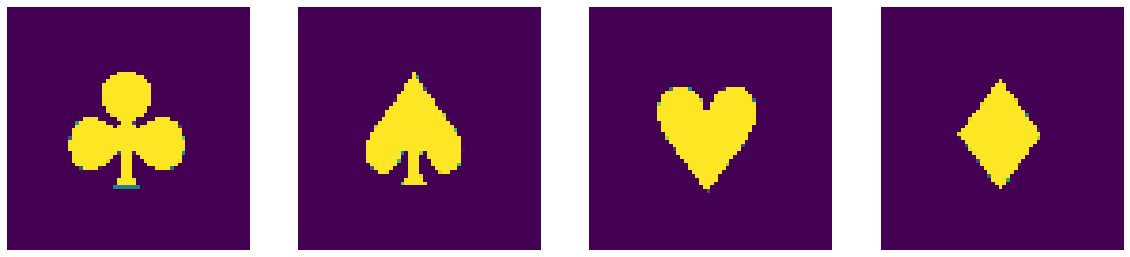

In [5]:
cards = get_data()

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,5))
ax1.imshow(cards[0])
ax1.axis('off')
ax2.imshow(cards[1])
ax2.axis('off')
ax3.imshow(cards[2])
ax3.axis('off')
ax4.imshow(cards[3])
ax4.axis('off');

In [6]:
# Labeled set (no transaltion, small rotations)
X_sup, y_sup = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=5, translation=None, 
    samples=200, seed=0)
# Unlabeled set (translation, large rotations)
X_unsup, _ = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1, 
    samples=3000, seed=1)
# Validation set (same as unlabeled, but using different seed)
X_val, y_val = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1, 
    samples=1000, seed=2)

Here's the supervised part of our training set:

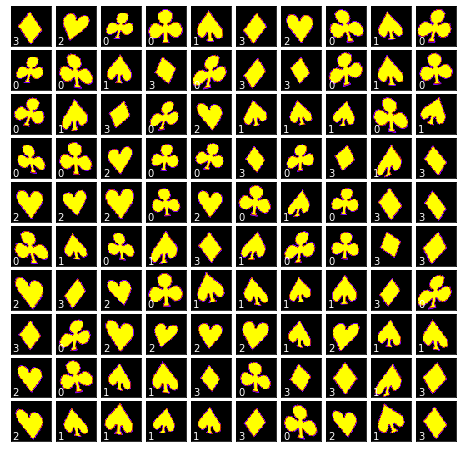

In [7]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_sup), size=(1,))
    im = X_sup[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_sup[i].argmax().item()),
            transform=ax.transAxes, color='white')

... and this is the unsupervised one. Note that here we have much larger orientational disorder as long as random offsets (in other words, the rotations and translations of the unlabeled data come from a different distribution than those of the labeled data!)

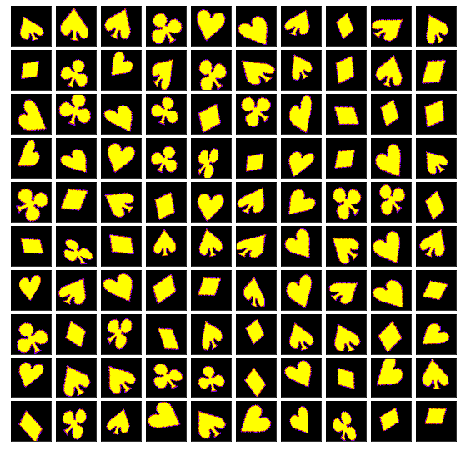

In [8]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_unsup), size=(1,))
    im = X_unsup[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')

Next, we create dataloaders:

In [9]:
(loader_unsup, loader_sup,
 loader_val) = pv.utils.init_ssvae_dataloaders(
     X_unsup, (X_sup, y_sup), (X_val, y_val), batch_size=64)

In [10]:
r = len(loader_sup) / (len(loader_unsup) + len(loader_sup))
print("Ratio of labeled data: {}".format(r))

Ratio of labeled data: 0.06467661691542288


## Train ss-(tr)VAE model

Finally, we will train a semi supervised (ss) VAE model. The goal is to use a limited amount (~6%) of labeled data with small positional (orientation+translation) disorder to categorize large volumes of unlabeled data characterized by a (much) higher positional disorder. During the training, we are also going to enforce **t**ranslational and **r**otational invariance (hence, *ss-tr*VAE)

Epoch: 1 Training loss: 813.7092, Test accuracy: 0.2915
Epoch: 2 Training loss: 513.9594, Test accuracy: 0.4738
Epoch: 3 Training loss: 472.4999, Test accuracy: 0.4945
Epoch: 4 Training loss: 429.1190, Test accuracy: 0.6300
Epoch: 5 Training loss: 399.4914, Test accuracy: 0.5703
Epoch: 6 Training loss: 380.3010, Test accuracy: 0.5938
Epoch: 7 Training loss: 367.3584, Test accuracy: 0.5945
Epoch: 8 Training loss: 355.3142, Test accuracy: 0.5830
Epoch: 9 Training loss: 344.6017, Test accuracy: 0.5865
Epoch: 10 Training loss: 331.5633, Test accuracy: 0.5960
Epoch: 11 Training loss: 321.5913, Test accuracy: 0.6058
Epoch: 12 Training loss: 313.7699, Test accuracy: 0.5988
Epoch: 13 Training loss: 305.5587, Test accuracy: 0.6375
Epoch: 14 Training loss: 300.6522, Test accuracy: 0.6755
Epoch: 15 Training loss: 290.8194, Test accuracy: 0.7125
Epoch: 16 Training loss: 286.6898, Test accuracy: 0.7660
Epoch: 17 Training loss: 281.7949, Test accuracy: 0.7762
Epoch: 18 Training loss: 274.6156, Test 

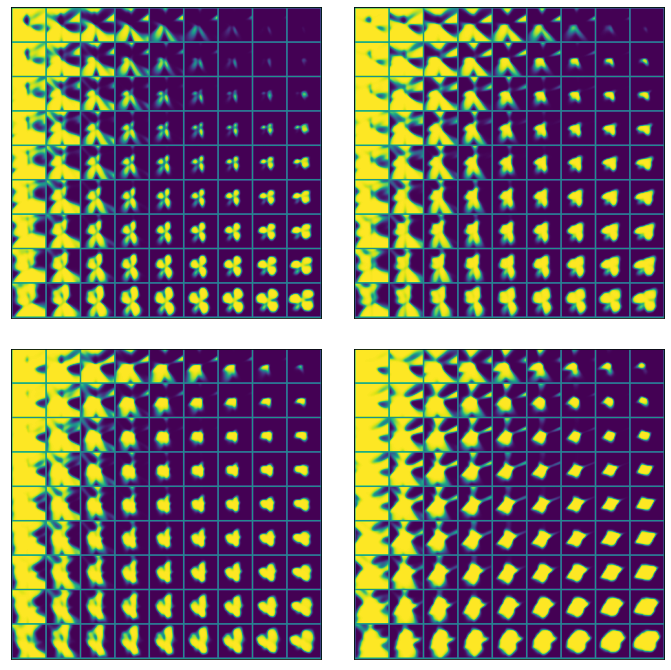

Epoch: 21 Training loss: 262.0341, Test accuracy: 0.8367
Epoch: 22 Training loss: 258.1837, Test accuracy: 0.8347
Epoch: 23 Training loss: 253.8080, Test accuracy: 0.8397
Epoch: 24 Training loss: 247.9226, Test accuracy: 0.8552
Epoch: 25 Training loss: 243.4700, Test accuracy: 0.8495
Epoch: 26 Training loss: 242.2707, Test accuracy: 0.8542
Epoch: 27 Training loss: 239.1320, Test accuracy: 0.8570
Epoch: 28 Training loss: 237.8835, Test accuracy: 0.8488
Epoch: 29 Training loss: 234.5286, Test accuracy: 0.8602
Epoch: 30 Training loss: 233.2551, Test accuracy: 0.8605
Epoch: 31 Training loss: 229.2345, Test accuracy: 0.8598
Epoch: 32 Training loss: 230.3765, Test accuracy: 0.8380
Epoch: 33 Training loss: 226.8151, Test accuracy: 0.8635
Epoch: 34 Training loss: 225.9449, Test accuracy: 0.8622
Epoch: 35 Training loss: 225.7258, Test accuracy: 0.8508
Epoch: 36 Training loss: 225.1721, Test accuracy: 0.8598
Epoch: 37 Training loss: 218.7798, Test accuracy: 0.8648
Epoch: 38 Training loss: 218.59

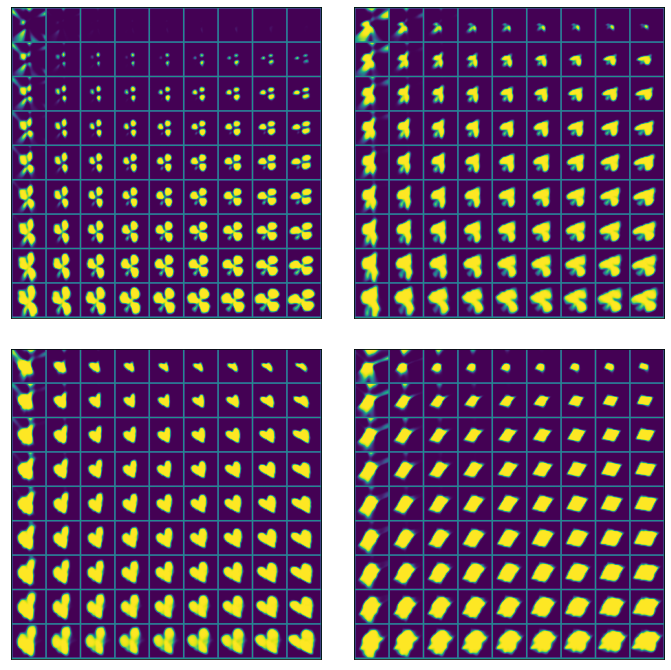

Epoch: 41 Training loss: 215.8939, Test accuracy: 0.8662
Epoch: 42 Training loss: 212.9632, Test accuracy: 0.8682
Epoch: 43 Training loss: 209.7544, Test accuracy: 0.8670
Epoch: 44 Training loss: 214.0759, Test accuracy: 0.8630
Epoch: 45 Training loss: 214.1276, Test accuracy: 0.8675
Epoch: 46 Training loss: 211.0672, Test accuracy: 0.8628
Epoch: 47 Training loss: 208.5483, Test accuracy: 0.8545
Epoch: 48 Training loss: 209.0439, Test accuracy: 0.8652
Epoch: 49 Training loss: 212.1889, Test accuracy: 0.8630
Epoch: 50 Training loss: 207.4874, Test accuracy: 0.8698
Epoch: 51 Training loss: 202.6962, Test accuracy: 0.8592
Epoch: 52 Training loss: 202.2664, Test accuracy: 0.8670
Epoch: 53 Training loss: 200.2980, Test accuracy: 0.8668
Epoch: 54 Training loss: 203.5901, Test accuracy: 0.8672
Epoch: 55 Training loss: 198.7335, Test accuracy: 0.8690
Epoch: 56 Training loss: 196.6776, Test accuracy: 0.8708
Epoch: 57 Training loss: 195.9556, Test accuracy: 0.8558
Epoch: 58 Training loss: 197.00

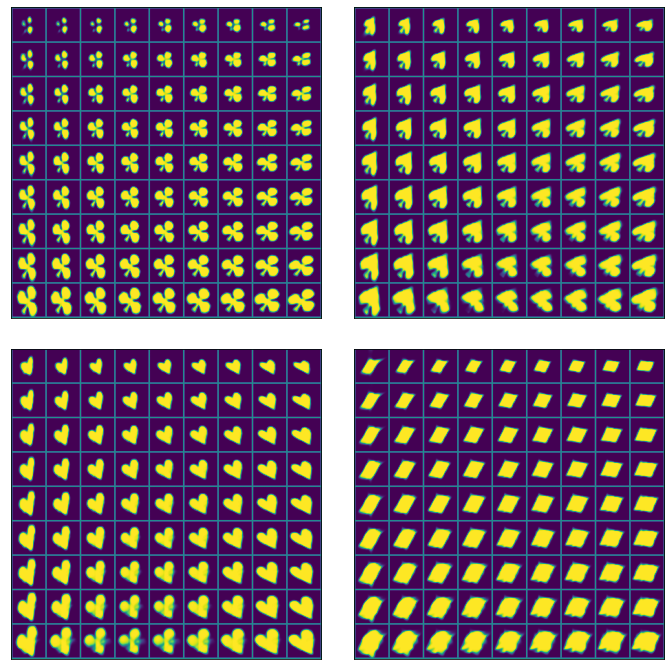

Epoch: 61 Training loss: 190.8014, Test accuracy: 0.8630
Epoch: 62 Training loss: 196.1984, Test accuracy: 0.8525
Epoch: 63 Training loss: 191.9792, Test accuracy: 0.8642
Epoch: 64 Training loss: 191.5222, Test accuracy: 0.8662
Epoch: 65 Training loss: 187.8789, Test accuracy: 0.8672
Epoch: 66 Training loss: 189.1623, Test accuracy: 0.8685
Epoch: 67 Training loss: 185.5437, Test accuracy: 0.8702
Epoch: 68 Training loss: 186.4353, Test accuracy: 0.8652
Epoch: 69 Training loss: 185.3538, Test accuracy: 0.8668
Epoch: 70 Training loss: 182.3819, Test accuracy: 0.8730
Epoch: 71 Training loss: 182.2409, Test accuracy: 0.8715
Epoch: 72 Training loss: 183.2333, Test accuracy: 0.8618
Epoch: 73 Training loss: 185.3606, Test accuracy: 0.8698
Epoch: 74 Training loss: 186.7250, Test accuracy: 0.8652
Epoch: 75 Training loss: 181.6639, Test accuracy: 0.8688
Epoch: 76 Training loss: 182.8828, Test accuracy: 0.8695
Epoch: 77 Training loss: 181.2434, Test accuracy: 0.8715
Epoch: 78 Training loss: 176.70

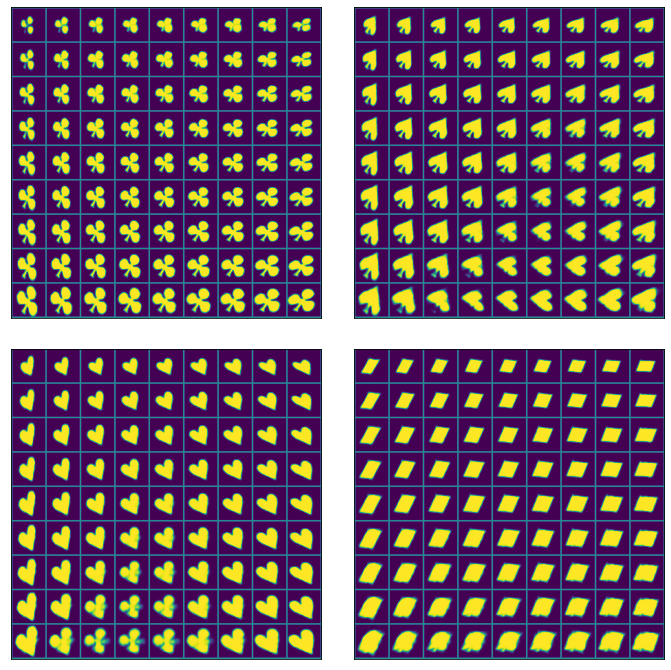

Epoch: 81 Training loss: 175.9353, Test accuracy: 0.8708
Epoch: 82 Training loss: 177.8497, Test accuracy: 0.8692
Epoch: 83 Training loss: 175.3107, Test accuracy: 0.8688
Epoch: 84 Training loss: 174.2057, Test accuracy: 0.8725
Epoch: 85 Training loss: 176.7094, Test accuracy: 0.8702
Epoch: 86 Training loss: 175.0393, Test accuracy: 0.8672
Epoch: 87 Training loss: 174.3017, Test accuracy: 0.8672
Epoch: 88 Training loss: 176.7722, Test accuracy: 0.8688
Epoch: 89 Training loss: 173.4038, Test accuracy: 0.8710
Epoch: 90 Training loss: 171.6752, Test accuracy: 0.8600
Epoch: 91 Training loss: 170.0568, Test accuracy: 0.8715
Epoch: 92 Training loss: 170.5129, Test accuracy: 0.8675
Epoch: 93 Training loss: 169.5403, Test accuracy: 0.8718
Epoch: 94 Training loss: 168.6531, Test accuracy: 0.8680
Epoch: 95 Training loss: 169.2107, Test accuracy: 0.8722
Epoch: 96 Training loss: 170.0037, Test accuracy: 0.8712
Epoch: 97 Training loss: 173.1701, Test accuracy: 0.8708
Epoch: 98 Training loss: 170.35

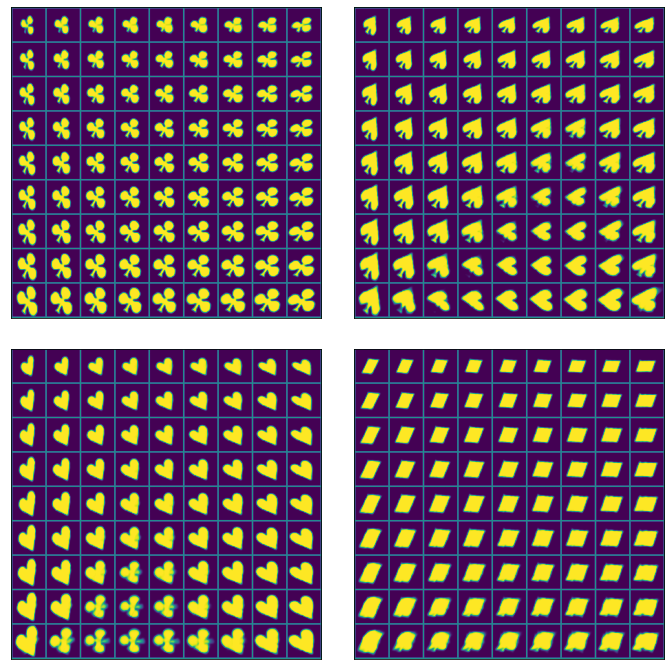

In [11]:
data_dim = (48, 48)
latent_dim = 2
num_classes = 4 
coord = 3  # coord=0: vanilla VAE, coord=1: rotations only, coord=2: translations only, coord=3: rotations+translations

# Initialize model
ssvae = pv.models.sstrVAE(
    data_dim, latent_dim, num_classes, coord,
    dx_prior=.1)

# Initialize trainer
trainer = pv.trainers.auxSVItrainer(ssvae)

# We're going to ramp-up KL weight from 1 to 2 in the first 30 epochs to improve the reconstruction quality
# Note, however, that for angles > 60 this could deteriorate the overall performance
kl_scale = torch.linspace(1, 2, 30)
# Train model for n epochs
for e in range(100):
    sc = kl_scale[e] if e < len(kl_scale) else kl_scale[-1]
    trainer.step(loader_unsup, loader_sup, loader_val,
                 aux_loss_multiplier=30, scale_factor=sc)
    trainer.print_statistics()
    # Plot learned altent manifolds every 10 epoch
    if (e+1) % 20 == 0:
        plot_manifolds(ssvae)

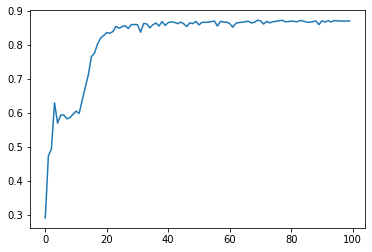

In [12]:
plt.plot(trainer.history["test_accuracy"])

Looks like we achieved ~87% accuracy with only ~6% of the data labeled! Furthermore, we were able to disentangle two main factors of data variation (beyond rotations and translations), namely, shear deformation and scale, which are encoded in the first (left to right) and second (top to bottom) latent variables. 

We can also plot traversals of the learned manifold where the horizontal direction corresponds to one of the continuous latent variables (while the other one is fixed at 0) and the vertical direction corresponds to the categorical variable:

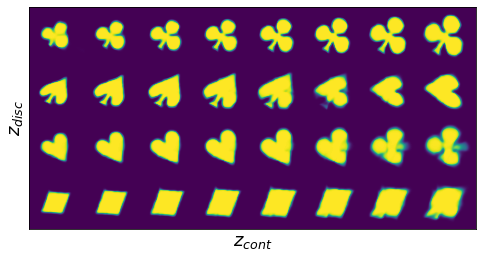

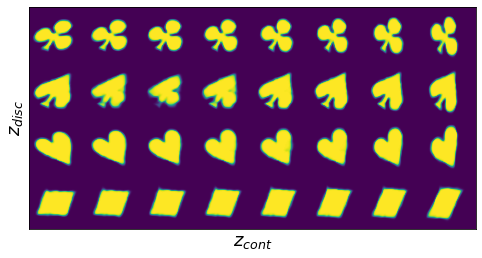

In [13]:
for i in range(2):
    ssvae.manifold_traversal(8, i, cmap='viridis')

## Confunsion Matrix Plot to look at the mislabeling

*Performed by Youngtao Liu*

In [14]:
# Make a data set for confusion matrix analysis
x_test, y_test = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1, 
    samples=3000, seed=2)

In [15]:
z_mu, _, c_test = ssvae.encode(x_test) 

In [16]:
#get prediction and true class
y_pred = np.array(c_test)  #prediction

y = np.array(y_test)
yy = np.where(y==1)
y_true = yy[1]    #true class 

In [17]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_true, y_pred)

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize =15)
    plt.yticks(tick_marks, classes, rotation=45, fontsize = 15)
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)

Normalized confusion matrix
[[9.27000000e-01 2.33333333e-03 7.06666667e-02 0.00000000e+00]
 [6.66666667e-04 9.66666667e-01 2.63333333e-02 6.33333333e-03]
 [6.66666667e-04 3.81000000e-01 6.18333333e-01 0.00000000e+00]
 [0.00000000e+00 2.66666667e-03 3.33333333e-04 9.97000000e-01]]


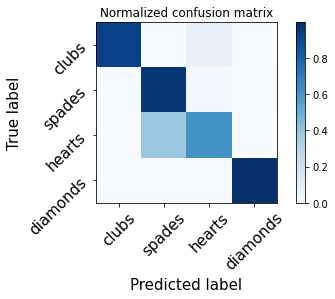

In [19]:
class_names = ['clubs', 'spades', 'hearts', 'diamonds']

#show confusion matrix plot
plt.figure()
plot_confusion_matrix(c_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Add noise to x_test

*Performed by Youngtao Liu*



*   Here I added two kinds of noise, one called background noise, the other called contaminaiton noise
*   Background noise: add background signal; this noise is determined by a noise_level parameter, which defines the intesnity of background
*   Contamination noise: add high-intensity signals in random pixels, this stimulates the contamination spot in experimental images. This noise is determined by contamination_level and contaminaiton_density, which defines the intensity and density of contamination, respectively.



In [20]:
#make a data set for confusion matrix analysis
x_test, y_test = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1, 
    samples=1000, seed=2)

#find out y_true first
y = np.array(y_test)
yy = np.where(y==1)
y_true = yy[1]    #true class 

Background noise function

In [21]:
#define a function to add background noise
def add_noise (imgs, img_num=0, noise_level=0.1):   #input includes x_test data, number of x_test images, and noise level
  img = np.array(imgs)
  resp_imgs = img.reshape(img_num,48,48)
  for i in range (img_num):
    original = resp_imgs[i]
    noise = np.random.normal(0, noise_level, original.shape)
    resp_imgs[i] = original + noise
  
  return resp_imgs.reshape(img_num, 2304)

Contamination noise function

In [22]:
#define a function to add contamination noise
def add_contamination (imgs, img_num, ctm_intensity = 0, ctm_density = 0.1): #input includes x_test data, number of x_test images, contaminaton level and contamination density
  img = np.array(imgs)

  for i in range (img_num):
    p=np.random.permutation(2304)
    img[i][p[:int(2304*ctm_density)]]=ctm_intensity
  
  return img

Look noise image and contaminated image

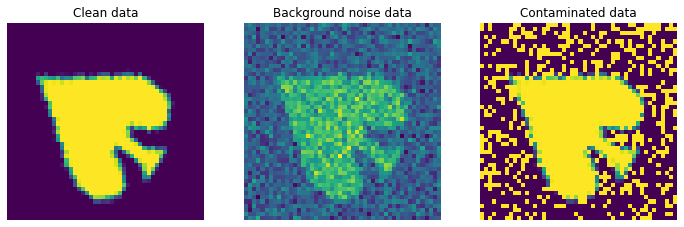

In [23]:
noise_x_test = add_noise(x_test, img_num = 4000, noise_level=0.3)
ctm_x_test = add_contamination(x_test, img_num = 4000, ctm_intensity = 1, ctm_density = 0.3)

k =1000
f, (ax1, ax2, ax3)= plt.subplots(1,3, figsize = (12,4))
ax1.imshow(x_test[k].view(48,48))
ax1.axis('off')
ax1.set_title('Clean data')

ax2.imshow(noise_x_test[k].reshape(48,48))
ax2.set_title('Background noise data')
ax2.axis('off')

ax3.imshow(ctm_x_test[k].reshape(48,48))
ax3.set_title('Contaminated data')
ax3.axis('off')
plt.show()

Analyze noise data using pre-trained model

(0.2, 0.9)

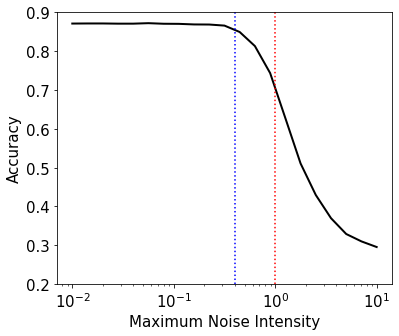

In [24]:
noise = np.linspace(-2,1,21)
noise_l = 10**noise
scores = []

for i in noise_l:
  noise_x_test = add_noise(x_test, img_num = 4000, noise_level=i)
  test = torch.from_numpy(noise_x_test)
  z_mu, _, c_test = ssvae.encode(test) 
  y_pred = np.array(c_test)
  score = (y_pred==y_true).sum()
  scores.append(score)

s = np.array(scores)/4000

f, ax = plt.subplots(figsize = (6,5))
plt.plot(noise_l, s, c = 'black', linewidth = 2)
plt.xscale('log')
plt.xlabel('Maximum Noise Intensity', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.axvline(x = 1, linestyle=":", c = 'r')
plt.axvline(x = 0.4, linestyle=":", c = 'b')
plt.tick_params('both', labelsize=15 )
plt.ylim(0.2,0.9)

Analyze contaminated data using pre-trained model

In [25]:
ctm_l = np.linspace(0,1,11)
ctm_d = np.linspace(0,0.5,11)

c_score_2D = np.zeros((11,11))

for i in range (11):
  for j in range (11):
    ctm_x_test = add_contamination(x_test, img_num = 4000, ctm_intensity = ctm_l[i], ctm_density = ctm_d[j])
    test = torch.from_numpy(ctm_x_test)
    z_mu, _, c_test = ssvae.encode(test) 
    y_pred = np.array(c_test)
    score = (y_pred==y_true).sum()
    c_score_2D[i,j] = score

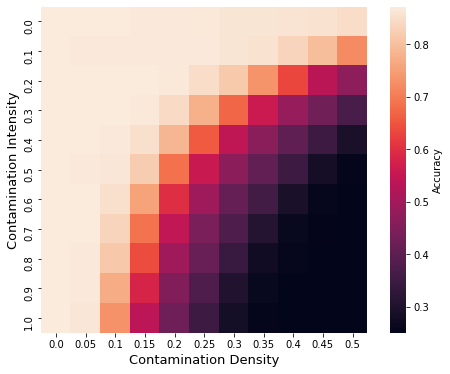

In [26]:
#heat map
import seaborn as sns

c_s_2D = np.array(c_score_2D)/4000

f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(c_s_2D, xticklabels=np.around(ctm_d,2), yticklabels=np.around(ctm_l,2), annot = False, square = True, cbar_kws={'label':'Accuracy'})
ax.set_ylabel ('Contamination Intensity', fontsize = 13)
ax.set_xlabel ('Contamination Density', fontsize = 13)
plt.show()

## Add more distortions

*Performed by Youngtao Liu*

Analyze data with varying shear and rotation using pre-trained model

In [27]:
sr = np.linspace(0,30,16)  #shear
ag = np.linspace(0,180, 16) #angle
score_2D = np.zeros((16,16)) #to store score

In [28]:
for i in range (16):
  for j in range (16):
    x_test, y_test = transform_images(*cards, shear=sr[i], scale=(1, 1.3), angle=ag[j], translation=0.1, samples=1000, seed=2)
    z_mu, _, c_test = ssvae.encode(x_test) 
    y_pred = np.array(c_test)
    y = np.array(y_test)
    yy = np.where(y==1)
    y_true = yy[1]    #true class 
    score = (y_pred==y_true).sum()
    score_2D[i,j] = score

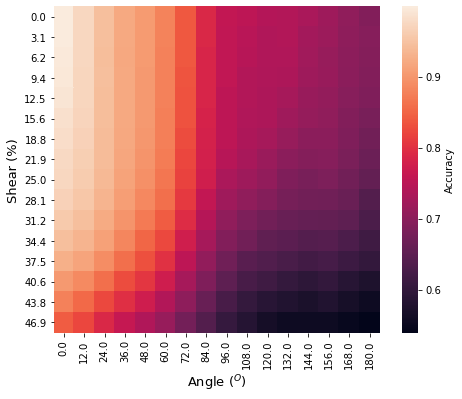

In [29]:
#heat map
ss_2D = np.array(score_2D)/4000

f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(ss_2D, xticklabels=ag, yticklabels=np.around(sr*100/64,1), annot = False, square = True, cbar_kws={'label':'Accuracy'})
ax.set_ylabel ('Shear (%)', fontsize = 13)
ax.set_xlabel ('Angle ($^O$)', fontsize = 13)
plt.show()